# Importing Libraries

__NOTE:__ 
- Training cell output is cleared from notebook
- All the final hyperparameters and depth of architecture is chosen based on experimentation on day_02 notebook
- Additional layer is added in the network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Building Artificial Neural Network (Very Basic)

## Hyperparameters

In [2]:
batch_size = 64
_lamda = 0.001
p = 0.5
learning_rate = 1e-3
epochs = 50

## Downloading and preprocessing data

In [3]:
base_folder = './data'
fashion_mnist_train = datasets.FashionMNIST(base_folder, download = True, train = True)
fashion_mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [4]:
train_images, train_labels = fashion_mnist_train.data, fashion_mnist_train.targets
print(f"Number of Training Images: {len(train_images)}")
print(train_images.shape, train_labels.shape)

Number of Training Images: 60000
torch.Size([60000, 28, 28]) torch.Size([60000])


In [5]:
print(f"Classes present in dataset: \n{fashion_mnist_train.classes}")

Classes present in dataset: 
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


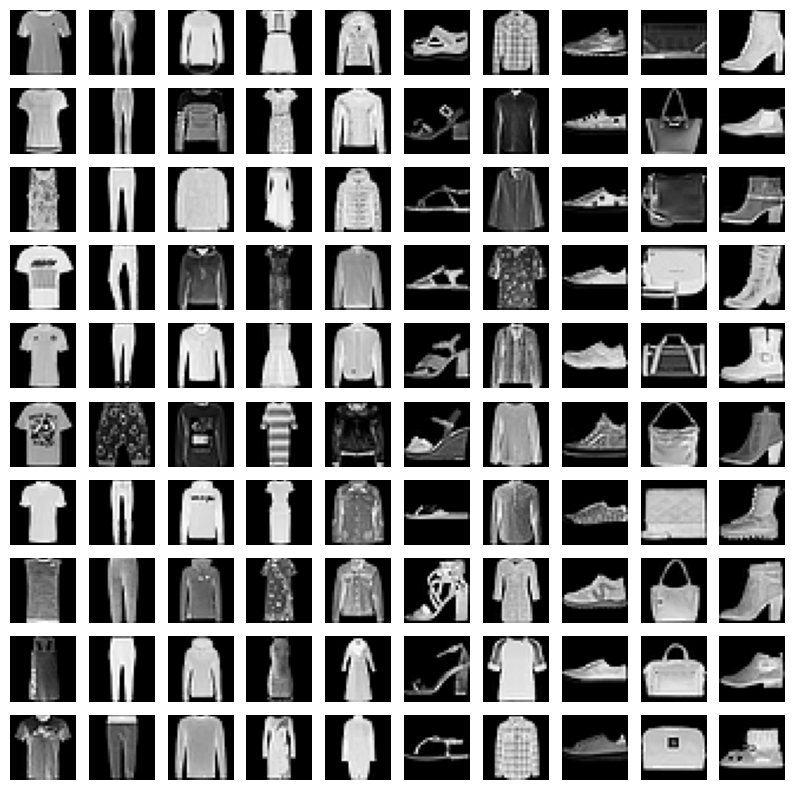

In [6]:
# Visualizing Data
unique_classes = np.unique(train_labels)
rows, cols = 10, len(unique_classes)
fig, axes = plt.subplots(rows, cols, figsize = (10,10))
i = 0
for _class in unique_classes:
    label_idx = np.where(train_labels == _class)[0]
    random_per_class = label_idx[np.random.choice(label_idx.shape[0], 10, replace = False)]
    for idx in random_per_class:
        img = train_images[idx]
        axes[i%10, i//10].imshow(img, cmap = 'gray')
        axes[i%10, i//10].axis('off')
        i+=1

In [7]:
fashion_mnist_valid = datasets.FashionMNIST(base_folder, download = True, train = False)
fashion_mnist_valid

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [8]:
valid_images, valid_labels = fashion_mnist_valid.data, fashion_mnist_valid.targets
print(f"Number of Valid Images: {len(valid_images)}")
print(valid_images.shape, valid_labels.shape)

Number of Valid Images: 10000
torch.Size([10000, 28, 28]) torch.Size([10000])


## Helper functions for training

In [9]:
class FMNISTDataset(Dataset):
    def __init__(self, imgs, lbls):
        # Flattening image
        self.imgs = imgs
        self.lbls = lbls
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img, lbl = self.imgs[idx], self.lbls[idx]
        
        # Normalize input image to be in between 0-1
        img = img / 255.
        
        # Flattening 2D image into a vector
        img = img.view(-1)
        return img, lbl

In [10]:
def get_data(bs = 64):
    train_data = FMNISTDataset(train_images, train_labels)
    trainloader = DataLoader(train_data, batch_size = bs, shuffle = True)
    valid_data = FMNISTDataset(valid_images, valid_labels)
    validloader = DataLoader(valid_data, batch_size = bs)
    return trainloader, validloader

def build_model(p = 0.5, lr = 1e-03):
    # Creating simple model with 1 hidden layer
    model = nn.Sequential(nn.Dropout(p),
                          nn.Linear(28*28, 1000),
                          nn.BatchNorm1d(1000),
                          nn.ReLU(),
                          nn.Dropout(p),
                          nn.Linear(1000, 500),
                          nn.BatchNorm1d(500),
                          nn.ReLU(),
                          nn.Dropout(p),
                          nn.Linear(500, 10))
    criterion = nn.CrossEntropyLoss()
    
    # Made changes in optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr)
    return model, criterion, optimizer

def train_batch(imgs, lbls, model, criterion, optimizer, valid = False, _lamda = 0.001):
    optimizer.zero_grad()
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    out = model(imgs)
    L2_reg = 0.0
    for parameter in model.parameters():
        L2_reg += torch.norm(parameter, 2)
    batch_loss = criterion(out, lbls)
    if not valid:
        final_loss = batch_loss + _lamda * L2_reg # _lambda is regularization hyperparam
        final_loss.backward()
        optimizer.step()
    return batch_loss.item()

def no_of_correct(imgs, lbls, model):
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    with torch.no_grad():
        model.eval()
        out = model(imgs)
        _, preds= out.max(-1)
        correct_preds = preds == lbls
        return correct_preds.cpu().numpy().sum(), len(lbls)

In [11]:
def train(epochs, learning_rate, _lamda, p):
    trainloader, validloader = get_data(batch_size)
    model, criterion, optimizer = build_model(p, learning_rate)
    train_accuracies, valid_accuracies = [], []
    train_losses, valid_losses = [], []
    for epoch in range(epochs):
        print(f"{'*'*10} EPOCH {epoch:2}/{epochs-1} {'*'*10}")
        batch_loss = 0.0
        model.train()
        for imgs, lbls in trainloader:
            batch_loss += train_batch(imgs, lbls, model, criterion, optimizer, _lamda = _lamda)

        total_correct = 0
        total = 0
        for imgs, lbls in trainloader:
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total

        epoch_train_acc = total_correct/total
        train_accuracies.append(epoch_train_acc)
        epoch_train_loss = batch_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Calculating for Valid data
        batch_loss = 0.0
        total_correct = 0
        total = 0
        for imgs, lbls in validloader:
            batch_loss += train_batch(imgs, lbls, model, criterion, optimizer, valid = True) # Don't need regularization hyperparam
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total

        epoch_valid_loss = batch_loss / len(validloader)
        epoch_valid_acc = total_correct / total
        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)

        print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}, Train Accuracy: {epoch_train_acc*100:5.2f}
Valid Loss: {epoch_valid_loss:5.3f}, Valid Accuracy: {epoch_valid_acc*100:5.2f}
{"#"*33}''')
        
    return train_losses, train_accuracies, valid_losses, valid_accuracies

## Training

In [ ]:
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate, _lamda = 0.001, p = 0.5)

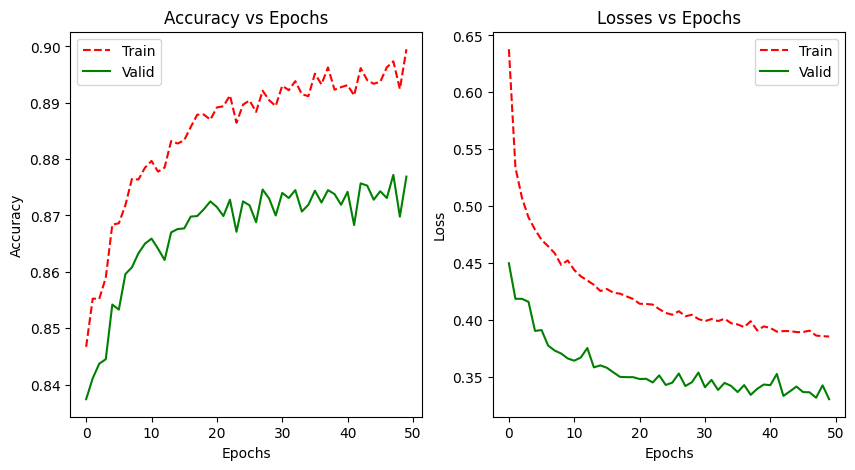

In [13]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();